# Python Function Comment Generator

By Derek Lilienthal and Dante Moon

### Defining the Problem

Because this is a generative model, blah blah blah stuff....

#### Measure of success

### Descriptions of the data

Link to datasets: https://github.com/github/CodeSearchNet

### Layout of the project
- Data Exploration and Pre-processing
- Baseline model
- Intermediate model
- Best model
- Conclusion

In [2]:
!pip install pysbd
!pip install langdetect
!pip install Keras==2.6.*

     |████████████████████████████████| 46 kB 9.4 MB/s             
     |████████████████████████████████| 278 kB 41.5 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=0e2b6bea398d2522fbada093d2eb7413579849de4476abef3395edc9fd9d927a
  Stored in directory: /home/datalore/.cache/pip/wheels/fe/cd/78/a7e873cc049759194f8271f780640cf96b35e5a48bef0e2f36
Successfully built pydotplus
     |████████████████████████████████| 71 kB 15.2 MB/s            
     |████████████████████████████████| 981 kB 42.6 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=f5594d175a357d4d7b7d40e9d95c9a40bb0e37142ad46b4dfc698232fc0c9af6
  Stored in directory: /home/datalore/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect
     |████████████████████████

In [3]:
#imports
import numpy as np
import pandas as pd
import os
from multiprocessing import Pool
import re
import pysbd # For sentence segmentation
from langdetect import detect_langs
import random
import string
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization, Flatten, Dense, Embedding, LSTM, RepeatVector, TimeDistributed, GRU, Bidirectional, Input
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from IPython.display import Image

## Data Exploration and Pre-processing

#### Preprocessing Coding Challenge Data 
*Loading in the data from directory*

In [3]:
#reading in the data
#https://www.kaggle.com/linkanjarad/coding-problems-and-solution-python-code?select=ProblemSolutionPythonV3.csv
#https://www.kaggle.com/veeralakrishna/python-code-data
df = pd.read_csv("Data/ProblemSolutionPythonV3.csv") #small dataset 1
with open('Data/Python_code_data.txt') as f: #small dataset 2
    lines = f.readlines()
f.close()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3307 entries, 0 to 3306
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   3307 non-null   int64 
 1   Problem      3307 non-null   object
 2   Python Code  3306 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.6+ KB


#### Exploring a few samples from both datasets

In [4]:
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()

,Problem,Python Code
0,Write a NumPy program to repeat elements of an...,"import numpy as np\rx = np.repeat(3, 4)\rprint..."
1,Write a Python function to create and print a ...,def printValues():\n\tl = list()\n\tfor i in r...
2,Write a Python program to remove duplicates fr...,"import itertools\rnum = [[10, 20], [40], [30, ..."
3,Write a NumPy program to compute the x and y c...,import numpy as np\rimport matplotlib.pyplot a...
4,Write a Python program to alter a given SQLite...,import sqlite3\rfrom sqlite3 import Error\rdef...


In [5]:
#reads in the file as a list of lines
lines[0:8]

['# write a python program to add two numbers \n',
 'num1 = 1.5\n',
 'num2 = 6.3\n',
 'sum = num1 + num2\n',
 "print(f'Sum: {sum}')\n",
 '\n',
 '\n',
 '# write a python function to add two user provided numbers and return the sum\n']

#### Cleaning Coding Challenge Data

Removing unnecessary language from the prompts, we do not need phrases like 'write a python function', 'write a numpy program', etc

In [6]:
#remove the first few words from the prompt 'write a python program' 'write a python function' ... etc
df['Problem']=df['Problem'].apply(lambda x: ' '.join(x.split()[5:]))

In [7]:
#explore df
df.head()

,Problem,Python Code
0,repeat elements of an array.,"import numpy as np\rx = np.repeat(3, 4)\rprint..."
1,create and print a list where the values are s...,def printValues():\n\tl = list()\n\tfor i in r...
2,remove duplicates from a list of lists.,"import itertools\rnum = [[10, 20], [40], [30, ..."
3,compute the x and y coordinates for points on ...,import numpy as np\rimport matplotlib.pyplot a...
4,alter a given SQLite table.,import sqlite3\rfrom sqlite3 import Error\rdef...


For the second dataset, it was provided as a txt file so we needed to identify what lines are code and what lines are the problem prompts/comments 

In [8]:
#keep track of what lines in .txt file are used for comments, two lists that will eventually become the dataframe for 
#holding the prompt and holding the code
comments = []
comment_lines = []
code = []

In [9]:
#for each line, if it starts with a '#' character, save that line as a comment line
for i in np.arange(len(lines)):
    if(lines[i][0]=='#'):
        comments.append(lines[i])
        comment_lines.append(i)

In [10]:
#testing to see which lines are comment lines
print(comment_lines[0:4])
print(lines[0])
print(lines[7])

[0, 7, 13, 27]
# write a python program to add two numbers 

# write a python function to add two user provided numbers and return the sum



In [11]:
#populate list of code
for index, elem in enumerate(comment_lines):
    if index+1 < len(comment_lines) and index - 1 >= 0:
        prev = comment_lines[index-1]
        code.append(lines[prev+1:elem])

In [12]:
#create dataframe
df1 = pd.DataFrame(list(zip(comments,code)),columns=['comments','code'])

In [13]:
#convert list of lines to one string
df1['code'] = df1['code'].apply(lambda x: ' '.join(x))

In [14]:
df1.head()

,comments,code
0,# write a python program to add two numbers \n,num1 = 1.5\n num2 = 6.3\n sum = num1 + num2\n ...
1,# write a python function to add two user prov...,"def add_two_numbers(num1, num2):\n sum = n..."
2,# write a program to find and print the larges...,\n num1 = 10\n num2 = 12\n num3 = 14\n if (num...
3,# write a program to find and print the smalle...,num1 = 10\n num2 = 12\n num3 = 14\n if (num1 <...
4,# Write a python function to merge two given l...,"def merge_lists(l1, l2):\n return l1 + l2\..."


In [15]:
#cleaning df1
df1['comments'] = df1['comments'].str.lower()
count = 0
remaining = 0
for row in df1['comments']:
    if len(df1['comments'][count].split())<=3: #removes lines that only have two words
        df1['comments'][count] = ''
    df1['comments'][count] = df1['comments'][count].replace('# write a python program to ','')
    df1['comments'][count] = df1['comments'][count].replace('# write a program to ','')
    df1['comments'][count] = df1['comments'][count].replace('# write program to ','')
    df1['comments'][count] = df1['comments'][count].replace('# write program which ','')
    df1['comments'][count] = df1['comments'][count].replace('# write a program which ','')
    df1['comments'][count] = df1['comments'][count].replace('# write a ','')
    df1['comments'][count] = df1['comments'][count].replace('# write python code to demonstrate ','')
    df1['comments'][count] = df1['comments'][count].replace('# write python3 code to demonstrate','')
    df1['comments'][count] = df1['comments'][count].replace('# please write a program which ','')
    df1['comments'][count] = df1['comments'][count].replace('# please write a program to ','')
    df1['comments'][count] = df1['comments'][count].replace('# define a function that can ','')
    df1['comments'][count] = df1['comments'][count].replace('# define a function which can ','')
    if df1['comments'][count].find('write a program to')!=-1:
        df1['comments'][count] = df1['comments'][count][df1['comments'][count].find('write a program to')+19:]
    if df1['comments'][count].find('write a python program that')!=-1:
        df1['comments'][count] = df1['comments'][count][df1['comments'][count].find('write a python program that')+28:]
    if df1['comments'][count].find('function to')!=-1:
        df1['comments'][count] = df1['comments'][count][df1['comments'][count].find('function to')+12:]
    if df1['comments'][count].find('program to')!=-1:
        df1['comments'][count] = df1['comments'][count][df1['comments'][count].find('program to')+11:]
    if df1['comments'][count].find('define')!=-1 and df1['comments'][count].find('class')!=-1:
        df1['comments'][count] = ""
    if df1['comments'][count].find('# in[')!=-1:
        df1['comments'][count] = ""
    if df1['comments'][count].find('printing result')!=-1:
        df1['comments'][count] = ""
    if df1['comments'][count].find('code to')!=-1:
        df1['comments'][count] = df1['comments'][count][df1['comments'][count].find('code to')+8:]
    if df1['comments'][count].find('function that')!=-1:
        df1['comments'][count] = df1['comments'][count][df1['comments'][count].find('function that')+14:]
    if df1['comments'][count].find('function which')!=-1:
        df1['comments'][count] = df1['comments'][count][df1['comments'][count].find('function which')+15:]
    if df1['comments'][count].find('#')==0:
        remaining+=1
    count+=1
print(df1.shape[0]-remaining,'clean examples')
print(remaining, 'remaining')
print(round(((df1.shape[0]-remaining)/df1.shape[0])*100,2) ,'% clean')

4111 clean examples
845 remaining
82.95 % clean


In [16]:
#replace empty prompts with null and then drop
df1['comments'].replace('', np.nan, inplace=True)
print(df1['comments'].isna().sum())
df1 = df1.dropna()
print(df1['comments'].isna().sum())
print(df1.shape)

365
0
(4591, 2)


In [17]:
#drop the remaining examples
df1 = df1[df1['comments'].str.find('#')==-1]
print(df1.shape)

(3735, 2)


In [18]:
df1.head()

,comments,code
0,add two numbers \n,num1 = 1.5\n num2 = 6.3\n sum = num1 + num2\n ...
1,add two user provided numbers and return the s...,"def add_two_numbers(num1, num2):\n sum = n..."
2,find and print the largest among three numbers\n,\n num1 = 10\n num2 = 12\n num3 = 14\n if (num...
3,find and print the smallest among three numbers\n,num1 = 10\n num2 = 12\n num3 = 14\n if (num1 <...
4,merge two given lists into one\n,"def merge_lists(l1, l2):\n return l1 + l2\..."


In [19]:
print(df1.columns)
print(df.columns)
df1.rename(columns={'comments':'Problem','code':'Python Code'},inplace=True)
print(df1.columns)

Index(['comments', 'code'], dtype='object')
Index(['Problem', 'Python Code'], dtype='object')
Index(['Problem', 'Python Code'], dtype='object')


In [20]:
df = df.append(df1)
df.shape

(7042, 2)

In [21]:
#lowercase everything
df['Problem']=df['Problem'].apply(lambda x: str(x).lower())
df['Python Code']=df['Python Code'].apply(lambda x: str(x).lower())

#### Preprocessing the CodeNet dataset

*Loading in data from directory*

In [7]:
data_dir = './Data'

In [23]:
codenet = pd.read_csv(os.path.join(data_dir, 'CodeNetData.csv'))
codenet.head()

,docstring,function
0,Trains a k-nearest neighbors classifier for fa...,"def train(train_dir, model_save_path=None, n_n..."
1,Recognizes faces in given image using a traine...,"def predict(X_img_path, knn_clf=None, model_pa..."
2,Shows the face recognition results visually.\n...,"def show_prediction_labels_on_image(img_path, ..."
3,Convert a dlib 'rect' object to a plain tuple ...,"def _rect_to_css(rect):\n """"""\n Convert ..."
4,"Make sure a tuple in (top, right, bottom, left...","def _trim_css_to_bounds(css, image_shape):\n ..."


Size of the dataset

In [24]:
codenet.shape

(503502, 2)

**Exploring some random samples**

*Click the cell below multiple times for different examples*

In [25]:
rand_example = np.random.choice(codenet.shape[0])
print("#"*120 + "\n" + "#"*22, "-"*30, " Docstring  ", "-"*30, "#"*22 + "\n" + "#"*120, '\n')
print(codenet['docstring'].iloc[rand_example])
print('\n' + "#"*120 + "\n" + "#"*22, "-"*30, "  Function  ", "-"*30, "#"*22 + "\n" + "#"*120, '\n')
print(codenet['function'].iloc[rand_example])

########################################################################################################################
###################### ------------------------------  Docstring   ------------------------------ ######################
######################################################################################################################## 

Get element with ``id``.

########################################################################################################################
###################### ------------------------------   Function   ------------------------------ ######################
######################################################################################################################## 

def getElementById(id: str) -> Optional[Node]:
    """Get element with ``id``."""
    elm = Element._elements_with_id.get(id)
    return elm


#### Steps for cleaning the docstrings and functions

**Docstring** <br>
1. Remove the line breaks
2. Remove the tabs
3. Remove the examples that starts with `return`, `Args`, `:param`, or `Parameters`
4. Remove the examples that are in another language
5. Remove the examples that contain more characters than just a `,` or `.` (No extra characters)
6. Remove `,` from examples 
7. Lowercase everything
8. Remove everything after the first sentence
9. Remove the period after the end of the sentence
10. Remove examples that are less than 3 words and more than 20
11. Remove any missing or blank examples

**Function** <br>
1. Remove everything between triple quotes
2. Remove functions that have more than 100 words or so
3. Remove any tabs, line breaks, extra white spaces and add spacing between commas, parentheses, and equal signs
5. Remove any missing or blank examples

*Note: running the code below can take a long time to process the data (45+ minutes sometimes). You can skip all the pre-processing steps and load in the cleaned data below. The step that takes this long is using the language detection (step 4) to remove any examples that are not in English on 500k+ examples. Even multi-threading this operations takes around 10 minutes on 14 cores*

In [26]:
codenet = pd.read_csv(os.path.join(data_dir, 'CodeNetData_cleaned.csv'))

**Cleaning docstring**

In [27]:
# ### Step 1
# codenet['docstring_cleaned'] = codenet['docstring'].apply(lambda x: str(x).split('\n\n')[0])

# ### Step 2
# codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: ' '.join(str(x).replace('\n',' ').split()))

# ### Step 3
# codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: x[:(None if str(x).find(':return:') == -1 else str(x).find(':return:'))])
# codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: x[:(None if str(x).find('Args') == -1 else str(x).find('Args'))])
# codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: x[:(None if str(x).find(':param') == -1 else str(x).find(':param'))])
# codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: x[:(None if str(x).find('Parameters') == -1 else str(x).find('Parameters'))])

# ### Step 4
# def detectEnglish(input):
#     try:
#         if(detect_langs(input)[0].lang=="en"):
#             return True
#         else: 
#             return False
#     except:
#         return False

# def add_features(df):       
#     df['docstring_isEnglish'] = df['docstring'].apply(lambda x: detectEnglish(str(x)))
#     return df

# def parallelize_dataframe(df, func, n_cores=8):
#     df_split = np.array_split(df, n_cores)
#     pool = Pool(n_cores)
#     df = pd.concat(pool.map(func, df_split))
#     pool.close()
#     pool.join()
#     return df

# codenet = parallelize_dataframe(codenet, add_features, n_cores=14) # Multi-threading 
# codenet = codenet[codenet['docstring_isEnglish'] == True]
# codenet = codenet.reset_index(drop=True) # reseting the index

# ### Step 5
# codenet = codenet[codenet['docstring_cleaned'].apply(lambda x: x.replace(' ','').replace(',','').replace('.','').isalpha())]
# codenet = codenet.reset_index(drop=True)

# ### Step 6
# codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: str(x).replace(',',''))

# ### Step 7
# codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: str(x).lower())

# ### Step 8
# seg = pysbd.Segmenter(language="en", clean=False)
# codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: seg.segment(x)[0])

# ### Step 9
# codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: str(x).rstrip('.'))

# ### Step 10
# codenet = codenet[codenet['docstring_cleaned'].apply(lambda x: len(x.split()) > 2)]
# codenet = codenet[codenet['docstring_cleaned'].apply(lambda x: len(x.split()) < 21)]

# ### Step 11
# codenet = codenet[codenet['docstring_cleaned'].astype(str) != ''] # Removing any docstrings that are empty
# codenet = codenet[codenet['docstring_cleaned'].isna() == False]
# codenet = codenet[codenet["docstring_cleaned"].astype(str) != 'None']
# codenet = codenet.reset_index(drop=True) # reseting the index

*Looking at the cleaned examples now*

In [28]:
rand_example = np.random.choice(codenet.shape[0])
print(f'Cleaned docstring: {codenet["docstring_cleaned"].iloc[rand_example]}\n')
print(f'Old docstring: {codenet["docstring"].iloc[rand_example]}')

Cleaned docstring: read managed objects instances

Old docstring: Read Managed Objects Instances.

        Given one or more py:class:`~pysnmp.smi.rfc1902.ObjectType` objects, read
        all or none of the referenced Managed Objects Instances.

        Parameters
        ----------
        varBinds: :py:class:`tuple` of :py:class:`~pysnmp.smi.rfc1902.ObjectType` objects
            representing Managed Objects Instances to read.

        Other Parameters
        ----------------
        \*\*context:

            Query parameters:

            * `cbFun` (callable) - user-supplied callable that is invoked to
                pass the new value of the Managed Object Instance or an error.
                If not provided, default function will raise exception in case
                of an error.

            * `acFun` (callable) - user-supplied callable that is invoked to
                authorize access to the requested Managed Object Instance. If
                not supplied, no access c

**Cleaning Functions**

In [29]:
# ### Step 1
# def remove_pydocs_doubleQ(text):
#     text = str(text)
#     try:
#         indexes_to_remove = []
#         for match in re.finditer('"""', text):
#             indexes_to_remove.append(match.start())  
#         return text[:indexes_to_remove[0]] + text[indexes_to_remove[1]+3:]
#     except:
#         pass
    
# codenet['function_cleaned'] = codenet['function'].apply(remove_pydocs_doubleQ)

# ### Step 2
# codenet = codenet[codenet['function_cleaned'].apply(lambda x: len(str(x).split())) < 101]

# ### Step 3
# def clean_function(text):
#     text_split = str(text).replace('\n',' ').replace('\t',' ').replace(',', ' , ').split()
#     text = ' '.join(text_split)
#     text = (text.replace('(', ' ( ').replace(')', ' ) ')
#             .replace('=',' = ').replace('"', ' " ')
#             .replace("'", " ' ").replace("#"," # ")
#             .replace('[',' [ ').replace(']', ' ] ')
#             .replace('{',' { ').replace('}', ' } ')
#             .replace(':', ' : ').replace('  ',' '))
#     return text

# codenet['function_cleaned'] = codenet['function_cleaned'].apply(clean_function)

# ### Step 4
# codenet = codenet[codenet['function_cleaned'].astype(str) != ''] # Removing any functions that are empty
# codenet = codenet[codenet['function_cleaned'].isna() == False] 
# codenet = codenet[codenet["function_cleaned"].astype(str) != 'None']
# codenet = codenet.reset_index(drop=True) # reseting the index

*Looking at the cleaned functions*

In [30]:
rand_example = np.random.choice(codenet.shape[0])
print(f'Cleaned function: \n{codenet["function_cleaned"].iloc[rand_example]}\n')
print(f'Old function: \n{codenet["function"].iloc[rand_example]}')

Cleaned function: 
def __call__ ( self , sid ) : return SyncListContext ( self._version , service_sid = self._solution [ ' service_sid ' ] , sid = sid , ) 

Old function: 
def __call__(self, sid):
        """
        Constructs a SyncListContext

        :param sid: The sid

        :returns: twilio.rest.sync.v1.service.sync_list.SyncListContext
        :rtype: twilio.rest.sync.v1.service.sync_list.SyncListContext
        """
        return SyncListContext(self._version, service_sid=self._solution['service_sid'], sid=sid, )


New shape of the pre-processed dataset

In [31]:
codenet.shape

(201624, 4)

In [32]:
codenet.head()

,docstring,docstring_cleaned,function,function_cleaned
0,Returns an array of bounding boxes of human fa...,returns an array of bounding boxes of human fa...,"def _raw_face_locations(img, number_of_times_t...","def _raw_face_locations ( img , number_of_time..."
1,Returns an array of bounding boxes of human fa...,returns an array of bounding boxes of human fa...,"def face_locations(img, number_of_times_to_ups...","def face_locations ( img , number_of_times_to_..."
2,Return the Catalyst datatype from the size of ...,return the catalyst datatype from the size of ...,"def _int_size_to_type(size):\n """"""\n Ret...",def _int_size_to_type ( size ) : if size < = 8...
3,Convert a schema from Spark to Arrow,convert a schema from spark to arrow,"def to_arrow_schema(schema):\n """""" Convert ...",def to_arrow_schema ( schema ) : import pyarro...
4,Convert schema from Arrow to Spark.,convert schema from arrow to spark,"def from_arrow_schema(arrow_schema):\n """""" ...",def from_arrow_schema ( arrow_schema ) : retur...


*Removing any hiddle characters*

In [33]:
codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: ''.join(line for line in x if line in string.printable))
codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: ''.join(line for line in x if line in string.printable))

In [34]:
# ### Saving the dataset to the data dir
# codenet[['docstring','docstring_cleaned','function','function_cleaned']].to_csv(os.path.join(data_dir, 'CodeNetData_cleaned.csv')

## Baseline model

This model mirrors a similar structure as the language translation notebook provided by Chollet. We selected this approach because it served as a good starting point that we could implement fairly quickly.

Create a list of code and comment pairs for the input and then print a random selection from that list.

In [184]:
code_pairs = []
for row in df.iterrows():
    #print('comment: ',row[1][0])
    #print('code: ',row[1][1])
    code_pairs.append((row[1][1],'[start] '+row[1][0]+' [end]'))

In [185]:
#print a random pair of code and prompt
print(random.choice(code_pairs))

('def group_similar_items(seq,el):\r    seq.append(seq.pop(seq.index(el)))\r    return seq \r\rcolors = [\'red\',\'green\',\'white\',\'black\',\'orange\']\rprint("original list:")\rprint(colors)\rel = "white"\rprint("move",el,"at the end of the said list:")\rprint(group_similar_items(colors, el))\r\rcolors = [\'red\',\'green\',\'white\',\'black\',\'orange\']\rprint("\\noriginal list:")\rprint(colors)\rel = "red"\rprint("move",el,"at the end of the said list:")\rprint(group_similar_items(colors, el))\r\rcolors = [\'red\',\'green\',\'white\',\'black\',\'orange\']\rprint("\\noriginal list:")\rprint(colors)\rel = "black"\rprint("move",el,"at the end of the said list:")\rprint(group_similar_items(colors, el))\r', '[start] move a specified element in a given list. [end]')


Set up training, validation, and test data and display the total number of pairs

In [186]:
random.shuffle(code_pairs)
num_validation_samples = int(0.15 * len(code_pairs))
num_training_samples = len(code_pairs) - 2 * num_validation_samples

train = code_pairs[:num_training_samples]
val = code_pairs[num_training_samples:num_training_samples + num_validation_samples]
test = code_pairs[num_training_samples + num_validation_samples:]
print(len(train) + len(val) + len(test), 'total pairs')

7042 total pairs


Next up, we need to calculate the size of the vocabulary using the built in Tokenizer from Keras

This works by splitting up each of the possible words found in the dataset and counting how many unique words are present

In [187]:
#figure out size of the vocabulary
tokenizer = Tokenizer()
full_text = df['Python Code'].tolist()
full_text.extend(df['Problem'].tolist())
tokenizer.fit_on_texts(full_text)
vocab_size = len(tokenizer.word_index)+1
print('vocabulary size: ',vocab_size)

vocabulary size:  13473


Now that we have the vocabulary size figured out, we need to determine how many words our output sequences should be. 

First lets calculate how many words are present for each of the problem prompts and add that as a column to the dataframe:

In [188]:
#figure out the output sequence length
df['word_count_problem']=df['Problem'].apply(lambda x: len(str(x).split()))

We want the sequence length to be appropriate for the largest amount of data without being too long, so we will select the 90th percentile value as our sequence length.

In [189]:
sequence_length = int(df.word_count_problem.quantile(0.90))
print('90th percentile length of the prompt: ',sequence_length)

90th percentile length of the prompt:  17


Using the TextVectorization function in order to turn our text into integers for the model to process. 

Here we used a combined vocabulary for both the code snippets and the problem prompts, but moving forward, it may be worth exploring how two different vocabularies impact our results. 

In [190]:
source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
)

Fit each of the vectorization layers to their respective data, one for the code snippets and one for comments:

In [191]:
train_code_texts = [pair[0] for pair in train]
train_comments_texts = [pair[1] for pair in train]
source_vectorization.adapt(train_code_texts)
target_vectorization.adapt(train_comments_texts)

**comment on batch size** 

**comment on make dataset**

In [192]:
batch_size = 16 #reduced from 64 to 32

def format_dataset(code, comment):
    code = source_vectorization(code)
    comment = target_vectorization(comment)
    return ({
        "code": code,
        "comment": comment[:, :-1],
    }, comment[:, 1:])
def make_dataset(pairs):
    code_texts, comment_texts = zip(*pairs)
    code_texts = list(code_texts)
    comment_texts = list(comment_texts)
    dataset = tf.data.Dataset.from_tensor_slices((code_texts, comment_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()
    
train_dataset = make_dataset(train)
val_dataset = make_dataset(val)

#### Model Architecture

According to a blog post from the TensorFlow team, they recommend embedding dimension should be set to the fourth root of your embedding vector (vocab_size in this case). However, in this example, that works out to be 11 and in execution, using too few embedding dimensions yielded higher loss and less accurate results 

In [231]:
round(vocab_size**0.25)

11

In the translation problem Chollet had a vocabulary size of 15,000 and used an embedding dimension of 256 and latent dimension of 1024, because our vocab size is similar, we will just keep the same values. 

**comment on structure of model**

In [222]:
embed_dim = 256
latent_dim = 1024  
 
source = layers.Input(shape=(None,), dtype="int64", name="code")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = layers.Bidirectional(layers.GRU(latent_dim), merge_mode="sum")(x) 

past_target = layers.Input(shape=(None,), dtype="int64", name="comment") 
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target) 
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)                       
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)   
seq2seq_rnn = tf.keras.Model([source, past_target], target_next_step)  

In [223]:
seq2seq_rnn.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
code (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
comment (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, None, 256)    3449088     code[0][0]                       
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, None, 256)    3449088     comment[0][0]                    
____________________________________________________________________________________________

In [224]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [225]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history = seq2seq_rnn.fit(train_dataset, epochs=30, validation_data=val_dataset,callbacks=[callback])

Epoch 1/30
309/309 [==============================] - 26s 58ms/step - loss: 2.9272 - accuracy: 0.2669 - val_loss: 2.5645 - val_accuracy: 0.3293
Epoch 2/30
309/309 [==============================] - 15s 47ms/step - loss: 2.4296 - accuracy: 0.3497 - val_loss: 2.3513 - val_accuracy: 0.3745
Epoch 3/30
309/309 [==============================] - 15s 48ms/step - loss: 2.2185 - accuracy: 0.3961 - val_loss: 2.2186 - val_accuracy: 0.4117
Epoch 4/30
309/309 [==============================] - 15s 48ms/step - loss: 2.0385 - accuracy: 0.4366 - val_loss: 2.0999 - val_accuracy: 0.4430
Epoch 5/30
309/309 [==============================] - 15s 48ms/step - loss: 1.8662 - accuracy: 0.4806 - val_loss: 2.0162 - val_accuracy: 0.4669
Epoch 6/30
309/309 [==============================] - 15s 48ms/step - loss: 1.7050 - accuracy: 0.5173 - val_loss: 1.9544 - val_accuracy: 0.4871
Epoch 7/30
309/309 [==============================] - 15s 48ms/step - loss: 1.5602 - accuracy: 0.5571 - val_loss: 1.8853 - val_accuracy:

In [226]:
def plot_metric(history, metric='loss'):
    """ Plot training and test values for a metric. """

    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show();

The model begins to overfit early and trains for 21 epochs before the early stopping callback for validation loss.

Later on we will explore the relationship between overfitting and the accuracy of our results, but for now this may be in part due to the amount of data we have. This model is only trained on a portion of the two smaller datasets.

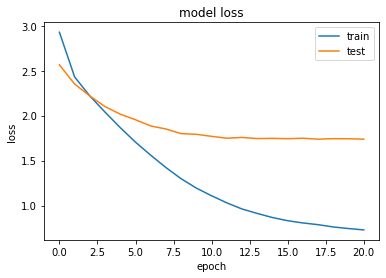

In [227]:
plot_metric(history)

This is the decoding function in order to translate the sequences back into plain text

In [228]:
comment_vocab = target_vectorization.get_vocabulary()            
comment_index_lookup = dict(zip(range(len(comment_vocab)), comment_vocab))   
max_decoded_sentence_length = sequence_length
 
def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[predicted]"                           
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(        
            [tokenized_input_sentence, tokenized_target_sentence])   
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = comment_index_lookup[sampled_token_index]         
        decoded_sentence += " " + sampled_token                  
        if sampled_token == "end":          
            break
    return decoded_sentence

Below are 20 random examples taken from the test data with the code, actual comment, and the predicted comment

In [232]:
test_code_texts = [pair[0] for pair in test] 
for _ in range(20):
    random_index = random.randrange(len(test_code_texts))
    input_sentence = test_code_texts[random_index]
    actual = test[random_index][1]
    #input_sentence = random.choice(test_code_texts)
    print("-")
    print(input_sentence)
    print('[actual] ',actual)
    print(decode_sequence(input_sentence))

-
def add_two_list_items():
     num1 = [1,2,3]
     num2 = [4,5,6]
     sum = num1 + num2
     print(f'sum: {sum}')
 
 

[actual]  [start] add two list of same length.
 [end]
[predicted] add two numbers end
-
def abc():
 x = 1
 y = 2
 str1= "w3resource"
 
 print(abc.__code__.co_nlocals)
 
 

[actual]  [start] detect the number of local variables declared in a function.
 [end]
[predicted] given a two given lists of integers as input and prints the words in a list sequence
-

 def heapsort(alist):
     build_max_heap(alist)
     for i in range(len(alist) - 1, 0, -1):
         alist[0], alist[i] = alist[i], alist[0]
         max_heapify(alist, index=0, size=i)
  
 def parent(i):
     return (i - 1)//2
  
 def left(i):
     return 2*i + 1
  
 def right(i):
     return 2*i + 2
  
 def build_max_heap(alist):
     length = len(alist)
     start = parent(length - 1)
     while start >= 0:
         max_heapify(alist, index=start, size=length)
         start = start - 1
  
 def max_heapify(alis

## Intermediate model

For the intermediate model, we will now be moving over to the CodeNet dataset because the CodeNet dataset is more complex than the previous two datasets. 

**Preprocessing each comment to have a unique start (\<starttoken\>) and stop (\<endtoken\>) token** <br>
This is needed in order for the model to generate consistent predictions

In [57]:
### Reading in the data to have a fresh start
codenet = pd.read_csv(os.path.join(data_dir, 'CodeNetData_cleaned.csv'))

codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: '<starttoken> '+ x.strip() +' <endtoken>')
codenet.head()

,docstring,docstring_cleaned,function,function_cleaned
0,Returns an array of bounding boxes of human fa...,<starttoken> returns an array of bounding boxe...,"def _raw_face_locations(img, number_of_times_t...","def _raw_face_locations ( img , number_of_time..."
1,Returns an array of bounding boxes of human fa...,<starttoken> returns an array of bounding boxe...,"def face_locations(img, number_of_times_to_ups...","def face_locations ( img , number_of_times_to_..."
2,Return the Catalyst datatype from the size of ...,<starttoken> return the catalyst datatype from...,"def _int_size_to_type(size):\n """"""\n Ret...",def _int_size_to_type ( size ) : if size < = 8...
3,Convert a schema from Spark to Arrow,<starttoken> convert a schema from spark to ar...,"def to_arrow_schema(schema):\n """""" Convert ...",def to_arrow_schema ( schema ) : import pyarro...
4,Convert schema from Arrow to Spark.,<starttoken> convert schema from arrow to spar...,"def from_arrow_schema(arrow_schema):\n """""" ...",def from_arrow_schema ( arrow_schema ) : retur...


**Splitting the up the functions by . and _** <br>
This allows us to have less unique tokens to choose from. 

In [58]:
codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: x.replace('.',' . '))
codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: ' '.join(x.split()))
codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: x.lower())
codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: x.replace('_',' _ '))

**Splitting the data into a training and validation set**

We are doing 5,000 testing examples and 150,000 training examples for this model

In [59]:
### Splitting the data into a training a validation set
X_train, X_test, y_train, y_test = train_test_split(codenet['function_cleaned'], codenet['docstring_cleaned'], test_size=5000, train_size=150000, random_state=41)

*Looking at the number of unqiue tokens in the training set*

In [60]:
### Creating a tokenizer for all the function tokens 
function_tokenizer = keras.preprocessing.text.Tokenizer(filters='')

### Fitting them to every value
function_tokenizer.fit_on_texts(X_train.values)
function_word_index = function_tokenizer.word_index
print(f"There are {len(function_word_index)} unique tokens in the training set of functions")

There are 167279 unique tokens in the training set of functions


**Preparing the input data for the Encoder**

Below we use the keras TextVectorizaiton layer to create our list of vocab words and their indexes. The TextVectorization allows us to get the top *n* most common words as our vocab instead of encoding each unique vocab word directly. This is an improvement over the previous ways of encoding text data by using the keras Tokenizer, and pad_sequences.

In [61]:
MAX_FUNCTION_LEN = 100
MAX_FUNCTION_WORDS = 100000

# One-hot encode the data
encoder_vectorizer = TextVectorization(
    standardize=None,
    max_tokens=MAX_FUNCTION_WORDS,
    output_mode='int',
    output_sequence_length=MAX_FUNCTION_LEN)
encoder_vectorizer.adapt(tf.data.Dataset.from_tensor_slices(X_train.tolist())) 

# Encode the training data to a vector by creating a model to do it for us
encoder_vectorize_model = Sequential()
encoder_vectorize_model.add(Input(shape=(None,), dtype=tf.string))
encoder_vectorize_model.add(encoder_vectorizer)
encoder_input_data = encoder_vectorize_model.predict([X_train])

# Save the vocabulary as a dictionary
function_word_index = dict(zip(encoder_vectorizer.get_vocabulary(), np.arange(MAX_FUNCTION_WORDS)))
NUM_FUNCTION_WORDS = len(function_word_index)
print(f'Found {NUM_FUNCTION_WORDS} unique function word tokens')

print(f'Encoder input data shape -> {encoder_input_data.shape}')

Found 100000 unique function word tokens
Encoder input data shape -> (150000, 100)


**Preparing the data for the decoder**

We created two seperate vocabularies instead of a single vocabulary list because we found that when we combined both, we would get comments generated where the model would predict an unknown token *[UNK]* fairly often. But when we forced the model to predict on the vocabulary of only the comments, we would no longer get comments containing *[UNK]*. 

In [64]:
MAX_COMMENT_LEN = 17 # 15 actual word plus start and stop tokens

# One-hot encode the data
decoder_vectorizer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=None,
    output_mode='int',
    output_sequence_length=MAX_COMMENT_LEN)
decoder_vectorizer.adapt(tf.data.Dataset.from_tensor_slices(y_train.tolist())) 

# Encode the training data to a vector
decoder_vectorize_model = Sequential()
decoder_vectorize_model.add(tf.keras.Input(shape=(None,), dtype=tf.string))
decoder_vectorize_model.add(decoder_vectorizer)
decoder_input_data = decoder_vectorize_model.predict([y_train])

comment_word_index = dict(zip(decoder_vectorizer.get_vocabulary(), np.arange(len(decoder_vectorizer.get_vocabulary()))))
NUM_COMMENT_WORDS = len(comment_word_index)
print(f'Found {NUM_COMMENT_WORDS} unique function word tokens')

print(f'Encoder input data shape -> {decoder_input_data.shape}')

Found 31230 unique function word tokens
Encoder input data shape -> (150000, 17)


*Reverse dictionary of the comments. This will be helpful for decoding the predictions*

In [67]:
reverse_comment_word_index = {v: k for k, v in comment_word_index.items()}

#### Model Architecture

We don't take credit for comming up with the design of this model. 
https://towardsdatascience.com/how-to-build-an-encoder-decoder-translation-model-using-lstm-with-python-and-keras-a31e9d864b9b

In [71]:
input_sequence = Input(shape=(MAX_FUNCTION_LEN,))
embedding = Embedding(input_dim=MAX_FUNCTION_WORDS, output_dim=512, mask_zero=True)(input_sequence)
encoder = LSTM(256, return_sequences=False)(embedding)

### Takes in an input vector and repeates it 'n' amount of times
r_vec = RepeatVector(MAX_COMMENT_LEN)(encoder) 

decoder = LSTM(256, return_sequences=True)(r_vec)

### Applies the same Dense layer over the 'n' number of unique tokens
output_sequence = TimeDistributed(Dense(NUM_COMMENT_WORDS, activation="softmax"))(decoder) 

enc_dec_model = Model(input_sequence, output_sequence)
enc_dec_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam')
enc_dec_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 100, 512)          51200000  
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               787456    
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 17, 256)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 17, 256)           525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 17, 31230)         8026110   
Total params: 60,538,878
Trainable params: 60,538,878
Non-trainable params: 0
_______________________________________________

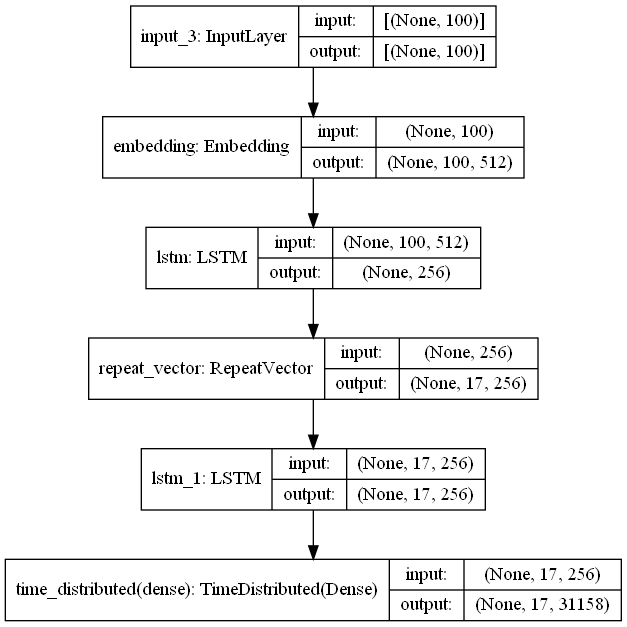

In [90]:
#keras.utils.plot_model(enc_dec_model, show_shapes=True)
Image(filename='./pics/Intermediate Model Arc.png')

**Training the model**

In [0]:
# history = enc_dec_model.fit(encoder_input_data, 
#                             decoder_input_data, 
#                             batch_size=512, 
#                             epochs=10, 
#                             validation_split=0.2, callbacks=[early_stopping])

*This is what the EPOCHS looked like during training*

Epoch 1/10 <br>
235/235 [==============================] - 61s 224ms/step - loss: 4.4460 - val_loss: 3.8865 <br>
Epoch 2/10 <br>
235/235 [==============================] - 52s 221ms/step - loss: 3.6765 - val_loss: 3.5241 <br>
Epoch 3/10 <br>
235/235 [==============================] - 52s 221ms/step - loss: 3.4829 - val_loss: 3.4612 <br>
Epoch 4/10 <br>
235/235 [==============================] - 52s 221ms/step - loss: 3.4744 - val_loss: 3.4176 <br>
Epoch 5/10 <br>
235/235 [==============================] - 52s 222ms/step - loss: 3.3958 - val_loss: 3.3878 <br>
Epoch 6/10 <br>
235/235 [==============================] - 52s 222ms/step - loss: 3.3493 - val_loss: 3.3549 <br>
Epoch 7/10 <br>
235/235 [==============================] - 52s 223ms/step - loss: 3.3025 - val_loss: 3.3599 <br>
Epoch 8/10 <br>
235/235 [==============================] - 52s 222ms/step - loss: 3.2585 - val_loss: 3.3255 <br>
Epoch 9/10 <br>
235/235 [==============================] - 53s 226ms/step - loss: 3.2118 - val_loss: 3.3252 <br>
Epoch 10/10 <br>
235/235 [==============================] - 52s 223ms/step - loss: 3.1642 - val_loss: 3.3300 <br>

*Loading the model instead of training it*

In [92]:
# history = enc_dec_model.fit(encoder_input_data, 
#                             decoder_input_data, 
#                             batch_size=512, 
#                             epochs=10, 
#                             validation_split=0.2, callbacks=[early_stopping])

enc_dec_model = tf.keras.models.load_model('saved_models/middle_encoder.h5')

OSError: OSError: SavedModel file does not exist at: saved_models/middle_encoder.h5/{saved_model.pbtxt|saved_model.pb}

In [0]:
def plot_history(history):
    """This function plots the training and validation loss"""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.figure(figsize=(6,4))
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    lowest_val_loss_epoch = np.argmin(val_loss)+1
    print("\nLowest Validation Loss: {:.4f} on epoch {}".format(np.min(val_loss), lowest_val_loss_epoch))

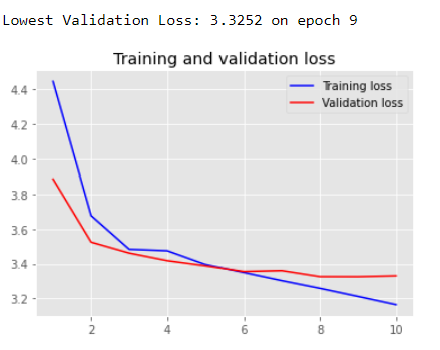

In [55]:
#plot_history(history)
Image(filename='./pics/Intermediate Model Training Graph.png')

**Making inferences**

In [76]:
def make_inferences(text):
    """
    This function takes in a python function that has been pre-processed and 
    generates a comment based on the models prediction
    """
    text_encoding = encoder_vectorize_model.predict([text])
    prediction = enc_dec_model.predict(text_encoding)
    
    output = ''
    
    for index in np.argmax(prediction[0], 1):
        if index == 2: # Start word
            continue
        # If the last word is the same as the predicted word or the current word is end
        if index == 3 or (len(output.split()) > 1 and 
                          str(output.split()[-1]) == str(reverse_comment_word_index[index])): 
            break
        output += ' ' + str(reverse_comment_word_index[index])
    return output

### Helper function to make the output look prettier
def rem_double_q(input):
    loc1 = input.find('\"\"\"')
    loc2 = input.find('\"\"\"',loc1+3)
    return input[:loc1]+input[loc2+3:]

**Testing on the training data**

In [0]:
example = np.random.choice(np.arange(X_train.shape[0]))
print("Actual Comment:", ' '.join(y_train.iloc[example].split()[1:-1]))
print()
print("Predicted Comments:", make_inferences(X_train.iloc[example]))
print()
print(f"Test Function:\n{rem_double_q(df['function'].loc[y_train.index[example]])}")

**Testing on data it's never seen before**

In [0]:
example = np.random.choice(np.arange(X_val.shape[0]))
print("Actual Comment:", ' '.join(y_val.iloc[example].split()[1:-1]))
print()
print("Predicted Comments:", make_inferences(X_val.iloc[example]))
print()
print(f"Test Function:\n{rem_double_q(df['function'].loc[y_val.index[example]])}")

## Best performing model

Some of the architecture for this model came from <br>
https://keras.io/examples/nlp/lstm_seq2seq/ <br>
https://colab.research.google.com/drive/11os3isH4I4X76dwOAQJ5cSRnfhmUziHm#scrollTo=2Mfco9WKukhS.

*Below is the same pre-processing steps as the previous model*

In [8]:
### Reading in the data to have a fresh start
codenet = pd.read_csv(os.path.join(data_dir, 'CodeNetData_cleaned.csv'))

codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: ''.join(line for line in x if line in string.printable))
codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: ''.join(line for line in x if line in string.printable))

codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: '<start> '+ x.strip() +' <end>')

codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: x.replace('.',' . '))
codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: ' '.join(x.split()))
codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: x.lower())
codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: x.replace('_',' _ '))

Because this model is more complex than the previous two models, we are not able to use all the data and can only train on 20,000 examples. This is partly due to the size of the embedding layers for both the functions and the comments themselves.

In [9]:
### Splitting the data into a training a validation set
X_train, X_val, y_train, y_val = train_test_split(codenet['function_cleaned'], codenet['docstring_cleaned'], 
                                                  test_size=5000, train_size=20000, random_state=41)

*Taking a look at how many unique tokens there are in the functions*

In [10]:
### Creating a tokenizer for all the function tokens 
function_tokenizer = keras.preprocessing.text.Tokenizer(filters='')

### Fitting them to every value
function_tokenizer.fit_on_texts(X_train.values)
function_word_index = function_tokenizer.word_index
NUM_FUNCTION_WORDS = len(function_word_index)
NUM_FUNCTION_WORDS

43619

**Preparing the input data for the Encoder**

In [11]:
MAX_FUNCTION_LEN = 100
MAX_FUNCTION_WORDS = 20000

# One-hot encode the data
encoder_vectorizer = TextVectorization(
    standardize=None,
    max_tokens=MAX_FUNCTION_WORDS,
    output_mode='int',
    output_sequence_length=MAX_FUNCTION_LEN)
encoder_vectorizer.adapt(tf.data.Dataset.from_tensor_slices(X_train.tolist())) 

# Encode the training data to a vector
encoder_vectorize_model = Sequential()
encoder_vectorize_model.add(tf.keras.Input(shape=(None,), dtype=tf.string))
encoder_vectorize_model.add(encoder_vectorizer)
encoder_input_data = encoder_vectorize_model.predict([X_train])

function_word_index = dict(zip(encoder_vectorizer.get_vocabulary(), np.arange(MAX_FUNCTION_WORDS)))
NUM_FUNCTION_WORDS = len(function_word_index)
print(f'Found {NUM_FUNCTION_WORDS} unique function word tokens')

print(f'Encoder input data shape -> {encoder_input_data.shape}')

Found 20000 unique function word tokens
Encoder input data shape -> (20000, 100)


**Prepairing the input data for the Decoder**

In [12]:
MAX_COMMENT_LEN = 15
MAX_COMMENT_WORDS = 5000

# One-hot encode the data
decoder_vectorizer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=None,
    output_mode='int',
    output_sequence_length=MAX_COMMENT_LEN)
decoder_vectorizer.adapt(tf.data.Dataset.from_tensor_slices(y_train.tolist())) 

# Encode the training data to a vector
decoder_vectorize_model = Sequential()
decoder_vectorize_model.add(tf.keras.Input(shape=(None,), dtype=tf.string))
decoder_vectorize_model.add(decoder_vectorizer)
decoder_input_data = decoder_vectorize_model.predict([y_train])

comment_word_index = dict(zip(decoder_vectorizer.get_vocabulary(), np.arange(len(decoder_vectorizer.get_vocabulary()))))
NUM_COMMENT_WORDS = len(comment_word_index)
print(f'Found {NUM_COMMENT_WORDS} unique function word tokens')

print(f'Encoder input data shape -> {decoder_input_data.shape}')

Found 11068 unique function word tokens
Encoder input data shape -> (20000, 15)


**Preparing the target data for the Decoder**<br>

The step needed to prepare the data for decoding is to remove the [starttoken] tab and then re-convert the responses to one-hot vectors. We do this so the decoder learned to predict everything after the first token and not the first token itself, all the way to the [endtoken] position. We one-hot encode the decoder data in order for us to get the index of the highest probability for our word in the comment index

In [13]:
decoder_target_data = list()
for token_seq in decoder_input_data:
    decoder_target_data.append( token_seq[1: ] ) # Removing the [Start] 
    
padded_y_train_lines = keras.preprocessing.sequence.pad_sequences(decoder_target_data, maxlen=MAX_COMMENT_LEN, padding='post' )
decoder_target_data = keras.utils.to_categorical(padded_y_train_lines, NUM_COMMENT_WORDS) 
print( 'Decoder target data shape -> {}'.format(decoder_target_data.shape))

Decoder target data shape -> (20000, 15, 11068)


In [14]:
print('There are {} examples. \nFor each example there are {} words\nFor each word there are {} possible words to choose from'.format(decoder_target_data.shape[0], decoder_target_data.shape[1], decoder_target_data.shape[2]))

There are 20000 examples. 
For each example there are 15 words
For each word there are 11068 possible words to choose from


In [15]:
# Create a reverse word index dict for turning numbers back into sentences
reverse_comment_word_index = {v: k for k, v in comment_word_index.items()}

**Model Design**

In [16]:
tf.keras.backend.clear_session()

EMBEDDING_DIM = 256
RNN_CELLS = 128

### ENCODER ###
encoder_inputs = layers.Input(shape=(None, ), name='Encoder Input (Functions)') # Allow for variable input lengths
encoder_embedding = layers.Embedding(input_dim=NUM_FUNCTION_WORDS, 
                                     output_dim=EMBEDDING_DIM, 
                                     mask_zero=True)(encoder_inputs)
encoder_outputs, state_h, state_c = layers.LSTM(RNN_CELLS, return_state=True)(encoder_embedding)
encoder_states = [ state_h , state_c ] # Saving the states to add to the decoder

### DECODER ###
decoder_inputs = layers.Input(shape=(None, ), name='Decoder Input (Comments)')
decoder_embedding = tf.keras.layers.Embedding(input_dim=NUM_COMMENT_WORDS, 
                                              output_dim=EMBEDDING_DIM, 
                                              mask_zero=True)(decoder_inputs)
decoder_lstm = layers.LSTM(RNN_CELLS, return_state=True, return_sequences=True)
decoder_outputs , _ , _ = decoder_lstm(decoder_embedding, initial_state=encoder_states ) # Adding the encoder states to the lstm decoder
decoder_dense = layers.Dense(NUM_COMMENT_WORDS, activation='softmax') 
output = decoder_dense(decoder_outputs)

### Joining together
model = Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder Input (Functions) (Inpu [(None, None)]       0                                            
__________________________________________________________________________________________________
Decoder Input (Comments) (Input [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    5120000     Encoder Input (Functions)[0][0]  
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2833408     Decoder Input (Comments)[0][0]   
______________________________________________________________________________________________

After creating the model, we can load in the weights instead of re-training.

In [17]:
model.load_weights(tf.train.latest_checkpoint('saved_weights/short_epochs'))

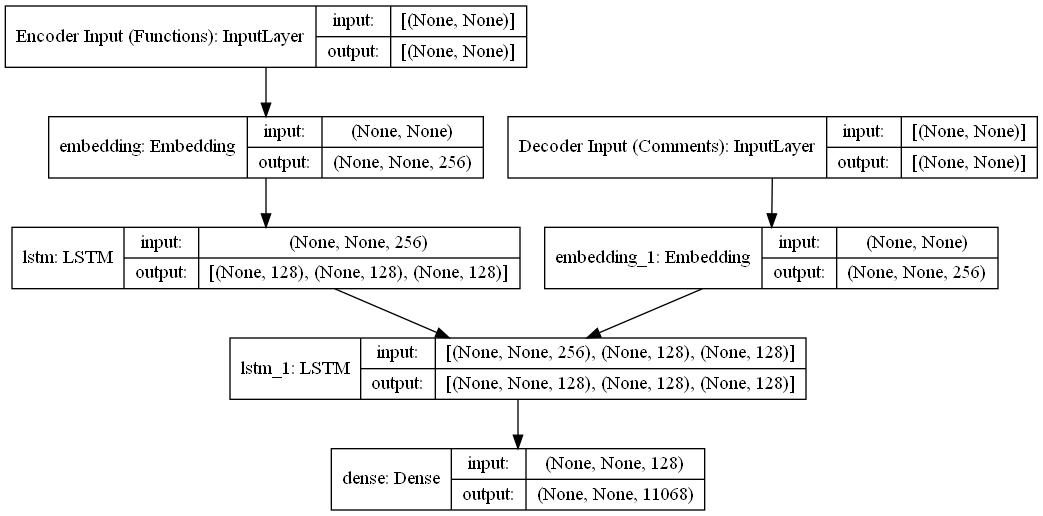

In [18]:
#keras.utils.plot_model(model, show_shapes=True)
Image(filename='./pics/Full Encoder.png')

In [19]:
# history = model.fit([encoder_input_data, decoder_input_data], 
#                     decoder_target_data,  
#                     epochs=75, 
#                     batch_size=32,
#                     validation_split=0.2)

Epoch 1/50 <br>
500/500 [==============================] - 20s 32ms/step - loss: 3.6440 - val_loss: 3.2847<br>
Epoch 2/50<br>
500/500 [==============================] - 13s 26ms/step - loss: 3.1462 - val_loss: 3.1728<br>
Epoch 3/50<br>
500/500 [==============================] - 13s 26ms/step - loss: 3.0114 - val_loss: 3.1276<br>
Epoch 4/50<br>
500/500 [==============================] - 13s 26ms/step - loss: 2.9093 - val_loss: 3.1054<br>
Epoch 5/50<br>
500/500 [==============================] - 13s 26ms/step - loss: 2.8183 - val_loss: 3.0912<br>
Epoch 6/50<br>
500/500 [==============================] - 13s 25ms/step - loss: 2.7278 - val_loss: 3.0855<br>
Epoch 7/50<br>
500/500 [==============================] - 13s 26ms/step - loss: 2.6345 - val_loss: 3.0902<br>
Epoch 8/50<br>
500/500 [==============================] - 13s 26ms/step - loss: 2.5419 - val_loss: 3.0972<br>
Epoch 9/50<br>
500/500 [==============================] - 13s 26ms/step - loss: 2.4527 - val_loss: 3.1222<br>

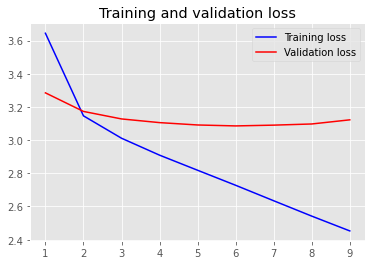

In [20]:
#plot_history(history)
Image(filename='./pics/Best Model Short Epochs.png')

In order for us to be able to make inferences, we need to create a new model from our trained model.

For the **encoder model**:
 - Input
  - Inputs of the encoder (functions that have been tokenized)
  - Trained encoder states 
 - Output
  - The state of the predicted function

For the **decoder model**: 
 - Input
  - Hidden (memmory) state of encoder model
  - Cell (carry) state of encoder model
 - Output
  - A softmax output of index in of the next word. Based on the index in the comment dictionary

In [21]:
def make_inference_models():
    
    encoder_model = Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=(RNN_CELLS ,), name='Hidden state')
    decoder_state_input_c = tf.keras.layers.Input(shape=(RNN_CELLS ,), name='Cell state')
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    
    return encoder_model, decoder_model

enc_model, dec_model = make_inference_models()

*Looking at the Encoder*

In [22]:
enc_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder Input (Functions) (I [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         5120000   
_________________________________________________________________
lstm (LSTM)                  [(None, 128), (None, 128) 197120    
Total params: 5,317,120
Trainable params: 5,317,120
Non-trainable params: 0
_________________________________________________________________


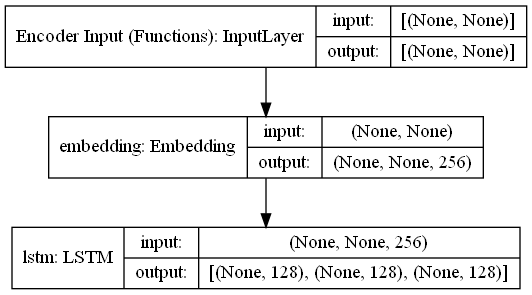

In [23]:
#keras.utils.plot_model(enc_model, show_shapes=True)
Image(filename='./pics/Encoder1.png')

*Looking at the Decoder*

In [24]:
dec_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder Input (Comments) (Input [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2833408     Decoder Input (Comments)[0][0]   
__________________________________________________________________________________________________
Hidden state (InputLayer)       [(None, 128)]        0                                            
__________________________________________________________________________________________________
Cell state (InputLayer)         [(None, 128)]        0                                            
____________________________________________________________________________________________

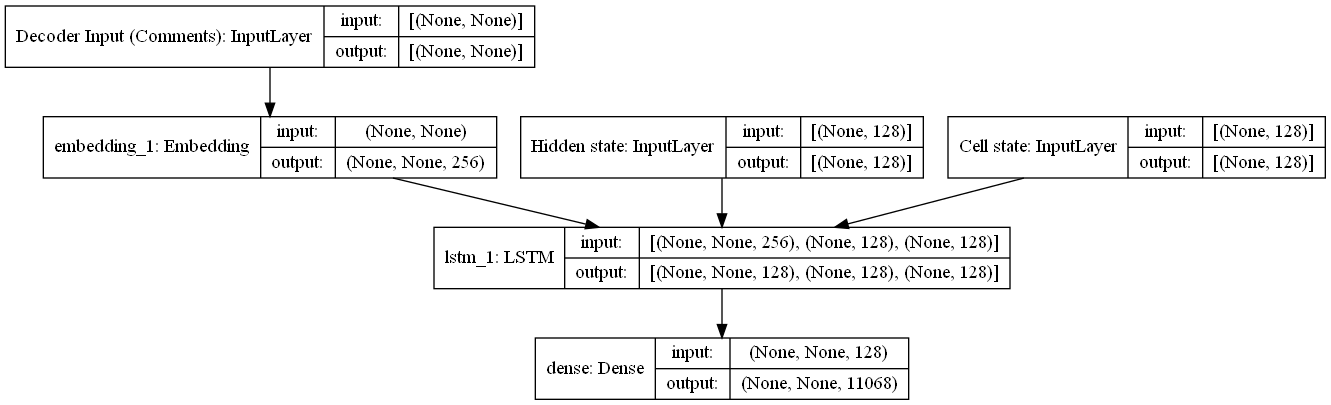

In [25]:
#keras.utils.plot_model(dec_model, show_shapes=True)
Image(filename='./pics/Decoder1.png')

In [26]:
# Helper function
def str_to_tokens( sentence : str ):
    """This function will pre-processed a cleaned function for predictions"""
    return encoder_vectorize_model.predict([sentence])

def rem_double_q(input):
    loc1 = input.find('\"\"\"')
    loc2 = input.find('\"\"\"',loc1+3)
    return input[:loc1]+input[loc2+3:]

def make_inferences(function: str):
    test_output = str_to_tokens(function)    
    
    # Predict the starting state values with the input 
    states_values = enc_model.predict( test_output )
    # Create a blank array to store the predictions
    empty_target_seq = np.zeros((1, 1))
    # Populate the predictions by including the starting token (1)
    empty_target_seq[0, 0] = comment_word_index['start']

    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        # Make a prediction given the previous word and the state values
        dec_outputs, h, c = dec_model.predict([ empty_target_seq ] + states_values )
        
        # Get the index of the word by getting the highest probability of the index predicted by the decoder model 
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )

        # Adding the word to the response
        sampled_word = None
        for word, index in comment_word_index.items():
            if sampled_word_index == index:
                decoded_translation += ' {}'.format( word )
                sampled_word = word

        # If we reach our stop word, the length of the comment is more than 20, or the last word is repeated
        if sampled_word == 'end' or len(decoded_translation.split()) > 20:
            stop_condition = True
            
        if len(decoded_translation.split()) > 1 and decoded_translation.split()[-1] == decoded_translation.split()[-2]:
            return ' '.join(decoded_translation.split()[:-2]).strip()

        # Reset the target sequence with the last predicted word as the starting point
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        # Reset the state values to the last state predicted by the decoder
        states_values = [ h , c ] 
    
    # Return the prediction as a string
    return ' '.join(decoded_translation.split()[:-1]).strip()

**Testing on the training data**

In [28]:
example = np.random.choice(np.arange(X_train.shape[0]))
print("Actual Comment:", ' '.join(y_train.iloc[example].split()[1:-1]))
print()
print("Predicted Comments:", make_inferences(X_train.iloc[example]))
print()
print(f"Test Function:\n{rem_double_q(codenet['function'].loc[y_train.index[example]])}")

Actual Comment: read a string from the slave

Predicted Comments: return a new instance of the given path

Test Function:
def read_string(self, registeraddress, numberOfRegisters=16, functioncode=3):
        
        _checkFunctioncode(functioncode, [3, 4])
        _checkInt(numberOfRegisters, minvalue=1, description='number of registers for read string')
        return self._genericCommand(functioncode, registeraddress, \
            numberOfRegisters=numberOfRegisters, payloadformat='string')


**Testing on data never seen before**

In [29]:
example = np.random.choice(np.arange(X_val.shape[0]))
print(example)
print("Actual Comment:", ' '.join(y_val.iloc[example].split()[1:-1]))
print()
print("Predicted Comments:", make_inferences(X_val.iloc[example]))
print()
print(f"Test Function:\n{rem_double_q(codenet['function'].loc[y_val.index[example]])}")

2139
Actual Comment: compute intersection of spectrum trail with arc line

Predicted Comments: run the number of all the current values in the given time

Test Function:
def intersection_spectrail_arcline(spectrail, arcline):
    

    # approximate location of the solution
    expected_x = (arcline.xlower_line + arcline.xupper_line) / 2.0

    # composition of polynomials to find intersection as
    # one of the roots of a new polynomial
    rootfunct = arcline.poly_funct(spectrail.poly_funct)
    rootfunct.coef[1] -= 1
    # compute roots to find solution
    tmp_xroots = rootfunct.roots()

    # take the nearest root to the expected location
    xroot = tmp_xroots[np.abs(tmp_xroots - expected_x).argmin()]
    if np.isreal(xroot):
        xroot = xroot.real
    else:
        raise ValueError("xroot=" + str(xroot) +
                         " is a complex number")
    yroot = spectrail.poly_funct(xroot)

    return xroot, yroot


### Re-training best model to sevearly overfit

Loading in the weights of the sevearly overfit model

In [30]:
model.load_weights(tf.train.latest_checkpoint('saved_weights/long_epochs'))

*Training plot of re-trained overfit model*

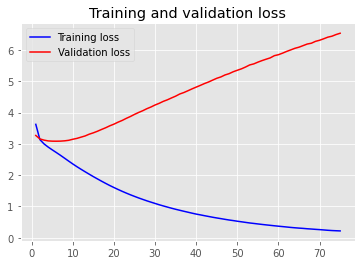

In [4]:
Image(filename='./pics/Best Model Long Epochs.png')

In [33]:
example = np.random.choice(np.arange(X_val.shape[0]))
print(example)
print("Actual Comment:", ' '.join(y_val.iloc[example].split()[1:-1]))
print()
print("Predicted Comments:", make_inferences(X_val.iloc[example]))
print()
print(f"Test Function:\n{rem_double_q(codenet['function'].loc[y_val.index[example]])}")

207
Actual Comment: adds a node object to the graph

Predicted Comments: adds a new blank node to the graph

Test Function:
def add_node(self, graph_node):
        

        if not isinstance(graph_node, Node):
            raise TypeError(
                'add_node() received ' +
                'a non node class object: ' + str(graph_node))


        node = self.get_node(graph_node.get_name())

        if not node:

            self.obj_dict['nodes'][graph_node.get_name()] = [
                graph_node.obj_dict ]

            #self.node_dict[graph_node.get_name()] = graph_node.attributes
            graph_node.set_parent_graph(self.get_parent_graph())

        else:

            self.obj_dict['nodes'][graph_node.get_name()].append(
                graph_node.obj_dict )

        graph_node.set_sequence(self.get_next_sequence_number())


### Passing your own function to make predictions on

In [34]:
def clean_function(text):
    """This function processes a python function to prepare for inferences"""
    text_split = str(text).replace('\n',' ').replace('\t',' ').replace(',', ' , ').split()
    text = ' '.join(text_split)
    text = (text.replace('(', ' ( ').replace(')', ' ) ')
            .replace('=',' = ').replace('"', ' " ')
            .replace("'", " ' ").replace("#"," # ")
            .replace('[',' [ ').replace(']', ' ] ')
            .replace('{',' { ').replace('}', ' } ')
            .replace(':', ' : ').replace('  ',' '))
    return text    

In [41]:
actual_function = '''
def sum(num1, num2):
    return num1 + num2
'''

test_example = clean_function(actual_function)

print("Predicted Comments:", make_inferences(test_example))
print()
print(f"Test Function:\n{actual_function}")

Predicted Comments: destroy this index

Test Function:

def sum(num1, num2):
    return num1 + num2



## Conclusion

To summarize the notebook, we first pre-processed all three of our data sources. 